## Multi-objective optimization of a dogbone design
---
 Based on "ASTM D638-14: Standard Test Method for Tensile Properties of Plastics 1"
 ASTM D638 Type I test specimen (165x19mm)


In [141]:
# Multi-objective optimization of infill patterns for a dogbone design
# using pymoo optimization library with structural objectives based on
# FEA evaluation in FEniCS framework with Gmsh meshing

import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation

from pymoo.termination import get_termination
from pymoo.optimize import minimize

import meshio
import gmsh
from dolfin import *

def create_mesh(mesh, cell_type):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:geometrical", cell_type)
    out_mesh = meshio.Mesh(points=mesh.points[:,:2], cells={cell_type: cells}, cell_data={"name_to_read": [cell_data]})
    return out_mesh


def extract_mesh_data(mesh_to_load):
    msh = meshio.read(mesh_to_load)

    # filepath management
    cwd = Path.cwd()
    temp_dir = cwd.joinpath("temp_mesh")   # temp dir for loading meshes
    temp_dir.mkdir(exist_ok=True)          # create parent dir if it does not exist


    infill_triangles = create_mesh(msh, "triangle")
    infill_lines = create_mesh(msh, "line")
    meshio.write(temp_dir / "mesh.xdmf", infill_triangles)
    meshio.write(temp_dir / "mf.xdmf", infill_lines)

    infill_mesh = Mesh()
    mvc = MeshValueCollection("size_t", infill_mesh, infill_mesh.topology().dim())
    with XDMFFile(str(temp_dir / "mesh.xdmf")) as infile:
        infile.read(infill_mesh)
        infile.read(mvc, "name_to_read")
    cf = cpp.mesh.MeshFunctionSizet(infill_mesh, mvc)

    mvc = MeshValueCollection("size_t", infill_mesh, infill_mesh.topology().dim() - 1)
    with XDMFFile(str(temp_dir / "mf.xdmf")) as infile:
        infile.read(mvc, "name_to_read")
    mf = cpp.mesh.MeshFunctionSizet(infill_mesh, mvc)

    infill_connect = infill_mesh.cells()       # triangle connectivity of the infill mesh
    infill_coords = infill_mesh.coordinates()  # coordinates within the infill mesh
    infill_coords = np.round(infill_coords, 4) # rounding the coordinates
    num_el = len(infill_connect)               # number of infill elements

    return infill_connect, infill_coords, num_el

def extract_mesh_data_fenics(mesh_to_load):
    msh = meshio.read(mesh_to_load)

    # filepath management
    cwd = Path.cwd()
    temp_dir = cwd.joinpath("temp_mesh")   # temp dir for loading meshes
    temp_dir.mkdir(exist_ok=True)          # create parent dir if it does not exist

    triangle_mesh = create_mesh(msh, "triangle")
    line_mesh = create_mesh(msh, "line")
    meshio.write(temp_dir / "mesh.xdmf", triangle_mesh)
    meshio.write(temp_dir / "mf.xdmf", line_mesh)

    mesh = Mesh()
    mvc = MeshValueCollection("size_t", mesh, mesh.topology().dim())
    with XDMFFile(str(temp_dir / "mesh.xdmf")) as infile:
        infile.read(mesh)
        infile.read(mvc, "name_to_read")
    cf = cpp.mesh.MeshFunctionSizet(mesh, mvc)

    mvc = MeshValueCollection("size_t", mesh, mesh.topology().dim() - 1)
    with XDMFFile(str(temp_dir / "mf.xdmf")) as infile:
        infile.read(mvc, "name_to_read")
    mf = cpp.mesh.MeshFunctionSizet(mesh, mvc)

    return mesh, mvc, cf, mf

def generate_infill_file(meshpath, infill_vec, infill_connect, infill_coords, verbosity=1, run_GUI=False):

    P = 1.2   # thickness of perimeters in mm
    LO = 165  # overall length
    WO = 19   # width overall
    WN = 13   # narrow section width
    LN = 57   # length of the narrow section
    RF = 76   # radius of the fillet
    G = 50    # gage length (streight length)
    T = 3.2   # thickness
    A = 36.36 # approximated gauge end

    GL = (LO - 50)/2  # gage step (from grip to narrow)
    DF = (WO-WN)/2    # side difference between narrow and grip

    num_el_x, num_el_y = 40, 10  # adjust the num of elements
    dx, dy = LO / num_el_x, WO / num_el_y


    # initialize Gmsh
    if not gmsh.is_initialized():
        gmsh.initialize()
        gmsh.option.setNumber('General.Verbosity', verbosity)

    gmsh.model.add(meshpath.stem)  # "smallSquare8-vecEl-substractive"


    # defining a namespace
    gmo = gmsh.model.occ  # gmo ~ gmsh.model.opencascade
    gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo

    # mesh sizes
    lc1 = dx   # mesh size grips
    lc2 = dx   # mesh size center section

    # defining the points
    gmo.addPoint(0, 0, 0, lc1, 1)
    gmo.addPoint(0, LO, 0, lc1, 2)
    gmo.addPoint(WO, LO, 0, lc1, 3)
    gmo.addPoint(WO, 0, 0, lc1, 4)
    gmo.addPoint(0, A, 0, lc1, 5)
    gmo.addPoint(0, LO-A, 0, lc1, 6)
    gmo.addPoint(WO, LO-A, 0, lc1, 7)
    gmo.addPoint(WO, A, 0, lc1, 8)
    gmo.addPoint(DF, GL, 0, lc2, 9)
    gmo.addPoint(DF, LO-GL, 0, lc2, 10)
    gmo.addPoint(WO-DF, LO-GL, 0, lc2, 11)
    gmo.addPoint(WO-DF, GL, 0, lc2, 12)
    gmo.addPoint(DF-RF, GL, 0, lc1, 13)
    gmo.addPoint(DF-RF,LO-GL, 0, lc1, 14)
    gmo.addPoint(WO-DF+RF, LO-GL, 0, lc1, 15)
    gmo.addPoint(WO-DF+RF, GL, 0, lc1, 16)

    # adding lines
    gmo.addLine(1, 5, 1)
    gmo.addLine(9, 10, 2)
    gmo.addLine(6, 2, 3)
    gmo.addLine(2, 3, 4)
    gmo.addLine(3, 7, 5)
    gmo.addLine(11, 12, 6)
    gmo.addLine(8, 4, 7)
    gmo.addLine(4, 1, 8)

    gmo.addEllipseArc(9, 13, 9, 5, 9)
    gmo.addEllipseArc(10, 14, 10, 6, 10)
    gmo.addEllipseArc(11, 15, 11, 7, 11)
    gmo.addEllipseArc(12, 16, 12, 8, 12)

    # defining a new surface:
    gmo.addCurveLoop([1, -9, 2, 10, 3, 4, 5, -11, 6, 12, 7, 8], 20)
    surf = gmo.addPlaneSurface([20])  # full surface
    gmo.synchronize()

    # subtracting individual infill elements
    infill_points = []   # list of point tags inside the infill
    for x, y in infill_coords:
        infill_points.append(gmo.addPoint(x, y, 0, lc1))  # add each point

    infill_lines = []   # list of line tags inside the infill
    infill_curves = []  # list of curve tags inside the infill
    infill_surfs = []   # list of surface tags
    for i, tri in enumerate(infill_connect):   # get each point in each triangle
        if infill_vec[i] == 0:                 # only if is to be deleted (0: not included)
            p1, p2, p3 = tri[0], tri[1], tri[2]
            tp1 = infill_points[p1]  # tag of p1
            tp2 = infill_points[p2]  # tag of p2
            tp3 = infill_points[p3]  # tag of p3
            l1 = gmo.addLine(tp1, tp2)  # tag of line 1
            l2 = gmo.addLine(tp2, tp3)  # tag of line 2
            l3 = gmo.addLine(tp3, tp1)  # tag of line 3
            xp1, yp1 = infill_coords[p1, 0], infill_coords[p1, 1]  # getting coords of p1
            xp2, yp2 = infill_coords[p2, 0], infill_coords[p2, 1]  # getting coords of p2
            xp3, yp3 = infill_coords[p3, 0], infill_coords[p3, 1]  # getting coords of p3
            infill_lines.append(l1)
            infill_lines.append(l2)
            infill_lines.append(l3)
            c1 = gmo.addCurveLoop([l1, l2, l3])
            s1 = gmo.addPlaneSurface([c1])  # create the surface
            infill_curves.append(c1)
            infill_surfs.append(s1)
    gmo.synchronize()

    surfs_to_cut = [(2, tag) for tag in infill_surfs]  # list of all surfs
    if len(surfs_to_cut) > 0:
        # substract all in one
        outlab = gmo.cut([(2, surf)], surfs_to_cut, removeObject=True, removeTool=True)
        surf = outlab[0][0][1]
        gmo.synchronize()

    # extract the curve boundary
    Boundary = [tg for tp, tg in gmsh.model.getBoundary([(2, surf)])]

    # adding physical groups
    gmsh.model.addPhysicalGroup(1, Boundary, name="SurfaceLoop") # curves physical group
    gmsh.model.addPhysicalGroup(2, [surf], name="PerimeterSurface")   # surfaces physical group
    gmo.synchronize()

    # global meshing options
    gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes


    # generate the mesh
    gmo.synchronize()
    gmsh.model.mesh.generate(2)

    # saving the mesh
    gmsh.write(str(meshpath))

    # Launch the GUI
    if run_GUI:
        gmo.synchronize()
        gmsh.fltk.run()

    # finish the GMSH session
    gmsh.finalize()


# def generate_img_file(meshpath, infill_vec, infill_connect, infill_coords, verbosity=1):
#     size = 10  # physical dimension of the side
#     P = 1      # number of perimeters
#     ex = 0.5   # extrusion width (one perimeter width)
#     width, height = size, size       # setting up the square
#     num_el_x, num_el_y = 2 * size, 2 * size  # adjust the num of elements
#     num_el_x_inf, num_el_y_inf = 7, 7  # adjust num of elems for infill
#     dx, dy = width / num_el_x, height / num_el_y
#
#     # initialize Gmsh
#     if not gmsh.is_initialized():
#         gmsh.initialize()
#         gmsh.option.setNumber('General.Verbosity', verbosity)
#
#     gmsh.model.add(meshpath.stem)  # "smallSquare8-vecEl-substractive"
#
#     # preparing parameters
#     lc = 3 * ex     # mesh size
#
#     # defining a namespace
#     gmo = gmsh.model.occ  # gmo ~ gmsh.model.opencascade
#     gmg = gmsh.model.geo  # gmg ~ gmsh.model.geo
#
#     # defining the points
#     gmo.addPoint(0, 0, 0, lc, 1)
#     gmo.addPoint(0, size, 0, lc, 2)
#     gmo.addPoint(size, size, 0, lc, 3)
#     gmo.addPoint(size, 0, 0, lc, 4)
#
#     # adding lines
#     gmo.addLine(1, 2, 1)
#     gmo.addLine(2, 3, 2)
#     gmo.addLine(3, 4, 3)
#     gmo.addLine(4, 1, 4)
#
#     # defining a new surface:
#     gmo.addCurveLoop([1, 2, 3, 4], 20)
#     surf = gmo.addPlaneSurface([20])  # full surface
#     gmo.synchronize()
#
#     # meshing the transfinite surface
#     gmsh.model.mesh.setTransfiniteCurve(1, num_el_x + 1)
#     gmsh.model.mesh.setTransfiniteCurve(2, num_el_x + 1)
#     gmsh.model.mesh.setTransfiniteCurve(3, num_el_x + 1)
#     gmsh.model.mesh.setTransfiniteCurve(4, num_el_x + 1)
#     gmo.synchronize()
#     gmsh.model.mesh.setTransfiniteSurface(surf, arrangement="Alternate", cornerTags=[1,2,3,4])
#
#
#     # subtracting individual infill elements
#     infill_points = []   # list of point tags inside the infill
#     for x, y in infill_coords:
#         infill_points.append(gmo.addPoint(x, y, 0, lc))  # add each point
#
#     infill_lines = []   # list of line tags inside the infill
#     infill_curves = []  # list of curve tags inside the infill
#     infill_surfs = []   # list of surface tags
#     for i, tri in enumerate(infill_connect):   # get each point in each triangle
#         if infill_vec[i] == 0:                 # only if is to be deleted (0: not included)
#             p1, p2, p3 = tri[0], tri[1], tri[2]
#             tp1 = infill_points[p1]  # tag of p1
#             tp2 = infill_points[p2]  # tag of p2
#             tp3 = infill_points[p3]  # tag of p3
#             l1 = gmo.addLine(tp1, tp2)  # tag of line 1
#             l2 = gmo.addLine(tp2, tp3)  # tag of line 2
#             l3 = gmo.addLine(tp3, tp1)  # tag of line 3
#             xp1, yp1 = infill_coords[p1, 0], infill_coords[p1, 1]  # getting coords of p1
#             xp2, yp2 = infill_coords[p2, 0], infill_coords[p2, 1]  # getting coords of p2
#             xp3, yp3 = infill_coords[p3, 0], infill_coords[p3, 1]  # getting coords of p3
#             infill_lines.append(l1)
#             infill_lines.append(l2)
#             infill_lines.append(l3)
#             c1 = gmo.addCurveLoop([l1, l2, l3])
#             s1 = gmo.addPlaneSurface([c1])  # create the surface
#             infill_curves.append(c1)
#             infill_surfs.append(s1)
#     gmo.synchronize()
#
#     surfs_to_cut = [(2, tag) for tag in infill_surfs]  # list of all surfs
#     if len(surfs_to_cut) > 0:
#         # substract all in one
#         outlab = gmo.cut([(2, surf)], surfs_to_cut, removeObject=True, removeTool=True)
#         surf = outlab[0][0][1]
#         gmo.synchronize()
#
#     # extract the curve boundary
#     Boundary = [tg for tp, tg in gmsh.model.getBoundary([(2, surf)])]
#
#     # adding physical groups
#     gmsh.model.addPhysicalGroup(1, Boundary, name="SurfaceLoop") # curves physical group
#     gmsh.model.addPhysicalGroup(2, [surf], name="PerimeterSurface")   # surfaces physical group
#     gmo.synchronize()
#
#     # global meshing options
#     gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay for 2D meshes
#
#     # setting up the appearence
#     gmsh.option.setNumber("Mesh.ColorCarousel", 0)  # visibility setup
#     gmsh.option.setNumber("Mesh.Triangles", 1)      # visibility setup
#     gmsh.option.setNumber("Geometry.Points", 0)     # visibility setup
#     gmsh.option.setNumber("Mesh.SurfaceFaces", 1)   # visibility setup
#     gmsh.option.setNumber("Mesh.Lines", 0)          # visibility setup
#     gmsh.option.setNumber("General.SmallAxes", 0)   # visibility setup
#     gmsh.option.setNumber("Mesh.LineWidth", 2)      # width setup
#     gmsh.option.setNumber("Mesh.Light", 0)          # light setup
#
#     #gmsh.option.setColor("Geometry.Color.Points", 255, 165, 0)  # setting the color
#     #gmsh.option.setColor("General.Color.Text", 255, 255, 255)   # setting the color
#
#     gmsh.option.setColor("Mesh.Color.Lines", 210, 200, 185)       # setting the color
#     gmsh.option.setColor("Mesh.Color.Triangles", 30, 30, 190)     # setting the color
#     #gmsh.option.setColor("Mesh.SurfaceFaces", 0, 255, 0, 1)
#     # gmsh.option.setColor("Mesh.SurfaceFaces", 0, 200, 0, 10)
#
#     # generate the mesh
#     gmo.synchronize()
#     gmsh.model.mesh.generate(2)
#
#     # Launch the GUI and saving the mesh
#     gmo.synchronize()
#     gmsh.fltk.initialize()
#     gmsh.write(str(meshpath))
#
#     # close the GUI
#     gmsh.fltk.finalize()
#
#     # finish the GMSH session
#     gmsh.finalize()

# load solutions from the txt file
def load_txt_solutions(path_solutions):  # out_dir / "sq_solutions.txt"
    with open(path_solutions, "r") as f:
        lines = f.readlines()
        header = lines[0]
        text = lines[1:]

        X = []
        F1, F2 = [], []
        for line in text:
            sline = line.split('\t')
            vec = sline[0].replace('[','').replace(']','').replace(' ','')
            x = [int(el) for el in vec.split(',')]
            x = np.array(x)

            f1 = sline[1].replace(' ','').split(':')[1]
            f1 = float(f1)
            f2 = sline[2].replace(' ','').split(':')[1]
            f2 = float(f2)

            X.append(x)
            F1.append(f1)
            F2.append(f2)
    F1, F2 = np.array(F1), np.array(F2)
    F = np.vstack((F1, F2)).T
    X = np.vstack(X)
    return F, X


In [324]:
# FEniCS functions setup

# boundary connection setup
tol = 0.1
def clamped_bottom(x, on_boundary): # beam is only fixed on the bottom
    return on_boundary and x[1] < tol

# Define strain
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    # return sym(nabla_grad(u))

# Define stress
def sigma(u, lambda_, d, mu):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Delta function for point load
class Delta(UserExpression):
    def __init__(self, eps, x0, **kwargs):
        self.eps = eps
        self.x0 = x0
        UserExpression.__init__(self, **kwargs)
    def eval(self, values, x):
        eps = self.eps
        values[0] = 0
        values[1] = eps/pi/(np.linalg.norm(x-self.x0)**2 + eps**2)
    def value_shape(self): return (2, )

# Distrubuted point load above certain height
class Load(UserExpression):
    def __init__(self, **kwargs):
        super().__init__(degree=kwargs["degree"])

        self.height = kwargs['height']
        self.value = kwargs['value']

    def eval(self, value, x):

        if x[1] > self.height:
            value[0] = self.value[0] / 10000
            value[1] = self.value[1] / 10000
        else:
            value[0] = 0
            value[1] = 0

    def value_shape(self):
        return (2,)


# Obtain max, total and average displacements
def get_displacement_measures(u, V):
    u_magnitude = sqrt(dot(u, u))
    u_magnitude = project(u_magnitude, V)
    u_magnitude = u_magnitude.vector()
    disp_len = u_magnitude.size()
    disp_max = u_magnitude.max()   # maximal displacement
    disp_tot = u_magnitude.sum()   # total/sum displacement
    disp_avg = disp_tot / disp_len # average displacement
    return disp_max, disp_tot, disp_avg

# returns displacements and vm stress for side-compression of the square
def dogbone_FEA(mesh, verbose=False, plotting=False):
    if not verbose:
        set_log_active(False)  # dolfin verbose to false
    else:
        set_log_active(True)   # dolfin verbose to true

    # Define function space for system of PDEs
    degree = 2
    lambda_ = 1
    mu = 1
    V = VectorFunctionSpace(mesh, 'P', degree)

    # Define boundary conditions
    bc1 = DirichletBC(V, Constant((0, 0)), clamped_bottom)
    bcs = [bc1]  # combined boundary conditions
    delta = Delta(eps=1E-1, x0=np.array([9.5, 165]), degree=5)  # point load at x0
    load = Load(height=162.5, value=(0, 2), degree=1)

    # Define variational problem
    u = TrialFunction(V)
    d = u.geometric_dimension()   # space dimension
    v = TestFunction(V)
    f = Constant((0, 0))
    T = Constant((0, 0))
    a = inner(sigma(u, lambda_, d, mu), epsilon(v)) * dx
    L = inner(load , v) * dx

    # Compute solution
    u = Function(V)
    solve(a == L, u, bcs)

    # Displacement measures
    V1 = FunctionSpace(mesh, 'P', 1)
    disp_max, disp_tot, disp_avg = get_displacement_measures(u, V1)


    # max Von Mises Stress measure
    s = sigma(u, lambda_, d, mu) - (1./3) * tr(sigma(u, lambda_, d, mu)) * Identity(d)  # deviatoric stress
    von_mises = sqrt(3./2 * inner(s, s))
    von_mises = project(von_mises, V1)
    max_von_mises = von_mises.vector().max()  # getting maximal von Mises stress

    if plotting:
        title_str = f"Displacement \n max:{round(disp_max,3)}  tot:{round(disp_tot,3)}  avg:{round(disp_avg,3)}"
        plot(u, title=title_str, mode='displacement')
        plt.show()

        plot(von_mises, title=f"Stress intensity, max vonMis:{max_von_mises}")###
        plt.show()

    return disp_max, disp_tot, disp_avg, max_von_mises


  Solving linear variational problem.


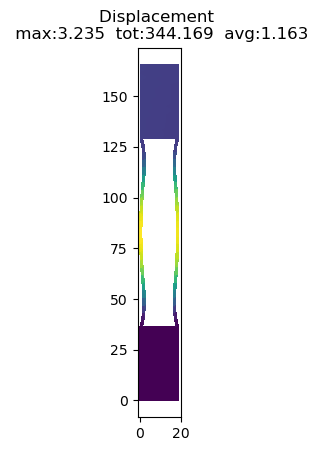

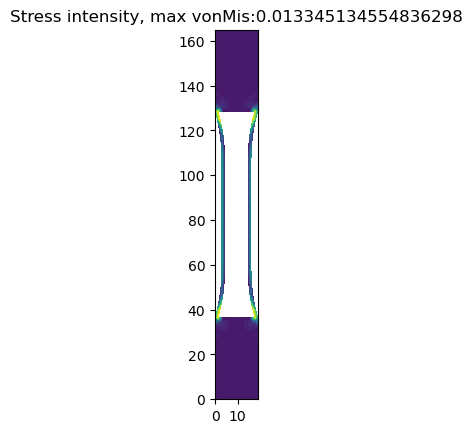

3.2346844712762453
0.013345134554836298


In [325]:
# Single iteration from Gmsh meshing to FEniCS in functions
import meshio
import gmsh
from ufl import nabla_div

cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "dogbones")  # adjust the dir here
inf_file = 'dogbone_type1-infill.msh'
mesh_inp = mesh_dir / inf_file

# Extracting geometry from the infill mesh
conn, coords, num_el = extract_mesh_data(mesh_inp)

# Create the mesh infill based on the infill vector
vec = np.random.randint(2, size=num_el)
vec = np.zeros(num_el)
meshfile = mesh_dir / 'infill_gen.msh'
generate_infill_file(meshfile, vec, conn, coords, run_GUI=False)

# Loading the created infill mesh to FEniCS
mesh, _, _, _ = extract_mesh_data_fenics(meshfile)

# perform FEA and obtain displacements and von mises stress
d_max, d_tot, d_avg, max_vm = dogbone_FEA(mesh, verbose=True, plotting=True)

print(d_max)
print(max_vm)